<a href="https://colab.research.google.com/github/chungntu/1DCNN-LSTM-ResNet/blob/main/Problem_9a_Bernoulli_beam_with_spring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


==================== SOLUTION ====================
=== DISPLACEMENTS (U) ===
  1   0.00000000e+00
  2   0.00000000e+00
  3  -4.32154320e+05
  4  -1.57438657e+05
  5  -6.17478390e+05
  6   7.40240753e+04
  7  -3.74990625e+02
  8   2.49943751e+05
  9   0.00000000e+00

=== REACTIONS at prescribed DOFs ===
DOF   1:  R =  6.25009375e+03
DOF   2:  R =  1.25009375e+04
DOF   9:  R =  3.74990625e+03


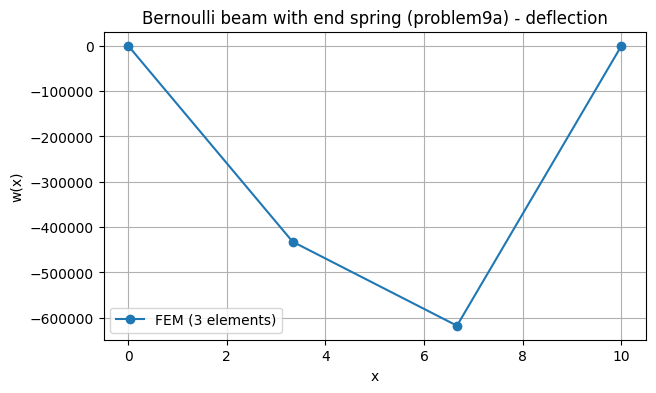


Exact solution (Bathe reduced system) X =
[-7.01816711e+05 -8.57907556e+05 -3.94727493e+02]

================ COMPARISON (RIGHT-END DEFLECTION) ================
FEM w_right              = -3.74990625e+02   |w|=3.74990625e+02
MATLAB quoted (magnitude)= 3.70000000e+02
Bathe quoted  (magnitude)= 3.90000000e+02

--- Error vs MATLAB quoted (by magnitude) ---
abs error  = 4.99062523e+00
rel error  = 1.349 %

--- Error vs Bathe quoted (by magnitude) ---
abs error  = 1.50093748e+01
rel error  = 3.849 %

--- FEM vs Bathe reduced-system X[2] (signed) ---
X[2] (Bathe) = -3.94727493e+02   |X[2]|=3.94727493e+02
abs error    = 1.97368681e+01
rel error    = 5.000 %



In [4]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# Bernoulli Beam + Spring FEM (problem9a.m) - FIXED
# MATLAB -> Python (Google Colab)
# ============================================================

def solve_system(GDof, prescribedDof, K, F, u_prescribed=None):
    """
    Solve KU=F with prescribed DOFs (1-based indexing like MATLAB in input).
    Prescribed displacements default to 0.
    """
    if u_prescribed is None:
        u_prescribed = np.zeros(len(prescribedDof), dtype=float)

    prescribed = np.array([d-1 for d in prescribedDof], dtype=int)  # 0-based
    all_dofs = np.arange(GDof, dtype=int)
    free = np.setdiff1d(all_dofs, prescribed)

    U = np.zeros(GDof, dtype=float)
    U[prescribed] = u_prescribed

    K_ff = K[np.ix_(free, free)]
    K_fp = K[np.ix_(free, prescribed)]
    F_f  = F[free]

    rhs = F_f - K_fp @ U[prescribed]
    U[free] = np.linalg.solve(K_ff, rhs)

    return U


def formStiffnessBernoulliBeam(GDof, numberElements, elementNodes, xx, EI, P):
    """
    2 DOF per node: [w, theta]
    Local stiffness (Euler-Bernoulli):
      k = EI/L^3 * [[12, 6L, -12, 6L],
                   [6L,4L^2,-6L,2L^2],
                   [-12,-6L,12,-6L],
                   [6L,2L^2,-6L,4L^2]]
    Consistent nodal load for uniform q=P:
      f = [ qL/2, qL^2/12, qL/2, -qL^2/12 ]^T
    """
    K = np.zeros((GDof, GDof), dtype=float)
    F = np.zeros(GDof, dtype=float)

    for e in range(numberElements):
        i, j = elementNodes[e, 0], elementNodes[e, 1]  # 1-based node ids

        # 0-based node indices
        i0 = i - 1
        j0 = j - 1

        # global dof indices (0-based)
        edof = np.array([2*i0, 2*i0+1, 2*j0, 2*j0+1], dtype=int)

        LE = xx[j0] - xx[i0]

        k1 = (EI / LE**3) * np.array([
            [ 12.0,    6.0*LE, -12.0,    6.0*LE],
            [  6.0*LE, 4.0*LE**2, -6.0*LE, 2.0*LE**2],
            [-12.0,   -6.0*LE,  12.0,   -6.0*LE],
            [  6.0*LE, 2.0*LE**2, -6.0*LE, 4.0*LE**2]
        ], dtype=float)

        f1 = np.array([
            P*LE/2.0,
            P*LE*LE/12.0,
            P*LE/2.0,
            -P*LE*LE/12.0
        ], dtype=float)

        K[np.ix_(edof, edof)] += k1
        F[edof] += f1

    return K, F


def outputDisplacementsReactions(U, K, F, prescribedDof):
    R = K @ U - F
    print("=== DISPLACEMENTS (U) ===")
    for i, ui in enumerate(U, start=1):
        print(f"{i:3d}  {ui: .8e}")

    print("\n=== REACTIONS at prescribed DOFs ===")
    for d in prescribedDof:
        print(f"DOF {d:3d}:  R = {R[d-1]: .8e}")


# ============================================================
# INPUT (same as problem9a.m screenshot)
# ============================================================

E = 1e6
L = 10.0
t = L / 1000.0
I = 1.0 * t**3 / 12.0
EI = E * I

numberElements = 3
nodeCoordinates = np.linspace(0.0, L, numberElements + 1)
xx = nodeCoordinates.copy()
numberNodes = len(xx)

elementNodes = np.column_stack([np.arange(1, numberElements+1),
                                np.arange(2, numberElements+2)]).astype(int)

P = -1000.0   # distributed load (downward)
k = 10.0      # spring stiffness (NOTE: screenshot uses k=10; figure may show 100)

GDof = 2 * numberNodes  # beam dofs only

# ============================================================
# Build beam K, F
# ============================================================

K_beam, F_beam = formStiffnessBernoulliBeam(GDof, numberElements, elementNodes, xx, EI, P)

# ============================================================
# Add spring as extra DOF (GDof+1 in MATLAB 1-based)
# stiffnessSpring size (GDof+1)
# ============================================================

K = np.zeros((GDof + 1, GDof + 1), dtype=float)
F = np.zeros(GDof + 1, dtype=float)

K[:GDof, :GDof] = K_beam
F[:GDof] = F_beam

# MATLAB: stiffnessSpring([GDof-1 GDof+1],[GDof-1 GDof+1]) += [k -k; -k k]
# Python 0-based:
#   MATLAB DOF (GDof-1) -> index (GDof-2)
#   MATLAB DOF (GDof+1) -> index (GDof)
spring_dofs = np.array([GDof-2, GDof], dtype=int)
K[np.ix_(spring_dofs, spring_dofs)] += k * np.array([[ 1.0, -1.0],
                                                     [-1.0,  1.0]], dtype=float)

# ============================================================
# Boundary conditions (as MATLAB)
# fixedNodeU=[1]; fixedNodeV=[2]; plus (GDof+1) for spring base
# ============================================================

fixedNodeU = [1]          # w at x=0
fixedNodeV = [2]          # theta at x=0
prescribedDof = fixedNodeU + fixedNodeV + [GDof + 1]  # spring base fixed

# ============================================================
# Solve
# ============================================================

U = solve_system(GDof + 1, prescribedDof, K, F)

# Output
print("\n==================== SOLUTION ====================")
outputDisplacementsReactions(U, K, F, prescribedDof)

# Deflection along beam
w = U[0:GDof:2]     # w at beam nodes
w_right = w[-1]     # right-end deflection

plt.figure(figsize=(7,4))
plt.plot(xx, w, "o-", label="FEM (3 elements)")
plt.grid(True)
plt.xlabel("x")
plt.ylabel("w(x)")
plt.title("Bernoulli beam with end spring (problem9a) - deflection")
plt.legend()
plt.show()

# ============================================================
# Bathe reduced-system (as in MATLAB code)
# ============================================================

load = np.array([L*P/3.0, L*P/3.0, L*P/6.0], dtype=float)

K_exact = (E*I/L**3) * np.array([
    [189.0, -108.0,  27.0],
    [-108.0, 135.0, -54.0],
    [ 27.0, -54.0, 27.0 + k*L**3/(E*I)]
], dtype=float)

X = np.linalg.solve(K_exact, load)

print("\nExact solution (Bathe reduced system) X =")
print(X)

# ============================================================
# Comparison (use magnitude to match typical reporting)
# ============================================================

w_matlab_quote = 0.0037e5  # 370
w_bathe_quote  = 0.0039e5  # 390

print("\n================ COMPARISON (RIGHT-END DEFLECTION) ================")
print(f"FEM w_right              = {w_right:.8e}   |w|={abs(w_right):.8e}")
print(f"MATLAB quoted (magnitude)= {w_matlab_quote:.8e}")
print(f"Bathe quoted  (magnitude)= {w_bathe_quote:.8e}")

print("\n--- Error vs MATLAB quoted (by magnitude) ---")
print(f"abs error  = {abs(abs(w_right) - w_matlab_quote):.8e}")
print(f"rel error  = {100*abs(abs(w_right) - w_matlab_quote)/w_matlab_quote:.3f} %")

print("\n--- Error vs Bathe quoted (by magnitude) ---")
print(f"abs error  = {abs(abs(w_right) - w_bathe_quote):.8e}")
print(f"rel error  = {100*abs(abs(w_right) - w_bathe_quote)/w_bathe_quote:.3f} %")

# In Bathe reduced system, X[2] is the right-end deflection (consistent with your output)
print("\n--- FEM vs Bathe reduced-system X[2] (signed) ---")
print(f"X[2] (Bathe) = {X[2]:.8e}   |X[2]|={abs(X[2]):.8e}")
print(f"abs error    = {abs(w_right - X[2]):.8e}")
print(f"rel error    = {100*abs(w_right - X[2])/(abs(X[2]) if X[2]!=0 else 1.0):.3f} %")
print("===================================================================\n")
